In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="You are using `torch.load` with `weights_only=False`")
warnings.filterwarnings("ignore", category=UserWarning, message="The PyTorch API of nested tensors is in prototype stage and will change in the near future.")

%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0,"/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre")
            
import torch
torch.set_printoptions(precision=10)


import yaml
torch.set_float32_matmul_precision('high')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
# load model 
from datasets.dataset_utils import  fp_loader_configer

fp_loader_configer.select_version("Hash_Entropy")
fp_loader = fp_loader_configer.fp_loader

import numpy as np 
import random
seed=2
torch.cuda.manual_seed_all(seed) 
np.random.seed(seed)
random.seed(seed)



choosing Hash_Entropy_FP_loader


In [2]:
import pickle
with open(f'/root/gurusmart/MorganFP_prediction/inference_data/coconut_loutus_hyun_training/inference_metadata_latest_RDkit.pkl', 'rb') as file:
    smiles_and_names = pickle.load(file)
print(len(smiles_and_names))

526316


In [3]:
from inference.inference_utils import choose_model 
from inference.inference_utils import save_molecule_inference
from inference.inference_utils import retrieve_top_k_by_rankingset, compute_cos_sim, unpack_inputs_no_delimiter, build_input, inference_topK
from utils.get_NP_class import get_superclass_and_glycoside

In [4]:
#### For infrastructure, 
#### run this:
# hparams, model  = choose_model_DB_specific_FP("C-NMR", include_test_loader = False)


hparams, model = choose_model("optional", return_data_loader=False)
from datasets.optional_2d_folder_dataset import OptionalInputDataModule

datamodule = OptionalInputDataModule(dir="/workspace/SMILES_dataset", FP_choice=hparams["FP_choice"], input_src=["HSQC", "oneD_NMR"], fp_loader = fp_loader_configer.fp_loader, batch_size=1, parser_args=hparams)



loading model from:  /root/gurusmart/MorganFP_prediction/reproduce_previous_works/entropy_on_hashes/flexible_models_jittering_flexible_MW_flexible_normal_hsqc/r0_r6_trial_1/checkpoints/epoch=95-step=21696.ckpt


Initialized SignCoordinateEncoder[784] with dims [365, 365, 54] and 2 positional encoders. 54 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
finish entropy list
Hash_Entropy_FP_loader is setup, out_dim=16384, max_radius=6


In [5]:
datamodule.setup("predict")
# loader_all_inputs, loader_HSQC_H_NMR, loader_HSQC_C_NMR, loader_only_hsqc, loader_only_1d, loader_only_H_NMR, loader_only_C_NMR = datamodule.test_dataloader()
test_dataloaders = datamodule.predict_dataloader()

In [6]:
max_radius = fp_loader.max_radius
rankingset_path = f"/root/gurusmart/MorganFP_prediction/inference_data/inference_rankingset_with_stable_sort/non_collision_FP_rankingset_max_radius_{max_radius}_dim_{hparams['out_dim']}_stacked_together/FP.pt"

rankingset_data = torch.load(rankingset_path)#.to("cuda")
rankingset_data = rankingset_data.to(model.device)


/opt/conda/lib/python3.11/site-packages/torch/_utils.py:315: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  result = torch.sparse_compressed_tensor(


In [7]:
from rdkit.Chem import rdFingerprintGenerator

def gen_mfp(smiles):
    MFP_generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
    mol = Chem.MolFromSmiles(smiles)
    fp = MFP_generator.GetFingerprint(mol)
    return torch.tensor(fp).float()

def cos_sim_of_smiles(smiles1, smiles2):
    try:
        fp1 = gen_mfp(smiles1)
        fp2 = gen_mfp(smiles2)
        cos_sim = torch.nn.functional.cosine_similarity(fp1, fp2, dim=0)
        return cos_sim.item()
    except Exception as e:
        return 0

from torch.nn.functional import cosine_similarity
import tqdm

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plot_order =['eHSQC, H NMR, and C NMR',
 'eHSQC and C NMR',
 'Normal HSQC and C NMR',
 'Normal HSQC, H NMR, and C NMR',
 'eHSQC and H NMR',
 'Normal HSQC and H NMR',
 'eHSQC Only',
 'Normal HSQC only',
 'C NMR and H NMR',
 'C NMR Only',
 'H NMR Only']

def plot_topk_accuracy(mean_rank_records, max_k=50, title="Structure Dereplication (Similarity = 1.0)"):
    """
    Plot Top-K accuracy curves for different models, sorted by performance in the legend.

    Args:
        mean_rank_records (dict): Dictionary mapping model names to lists of ranks.
        max_k (int): Maximum K value to plot.
        title (str): Plot title.
    """

    plt.figure(figsize=(10, 15))

    # Define a list of distinct colors
    # These colors are chosen for better visual separation than default matplotlib colors.
    colors = [
        '#E6194B', '#3CB44B', '#FFE119', '#4363D8', '#F58231',
        '#911EB4', '#46F0F0', '#F032E6', 
        '#008080',  '#9A6324', '#000075', '#808080'
    ]

    # Calculate Top-K accuracy for each model and store for sorting
    model_performance = {}
    for model_name, ranks in mean_rank_records.items():
        topk_accuracies = []
        for k in range(1, max_k + 1):
            correct_count = sum(1 for rank in ranks if rank < k)
            accuracy = (correct_count / len(ranks)) * 100
            topk_accuracies.append(accuracy)
        # Store the calculated accuracies and the model name
        model_performance[model_name] = topk_accuracies

    # Sort models by their final accuracy (at max_k) in descending order
    # sorted_models = sorted(model_performance.items(), key=lambda item: item[1][-1], reverse=True)

    # for i, (model_name, topk_accuracies) in enumerate(sorted_models):
    for i, model_name in enumerate(plot_order):
        topk_accuracies = model_performance[model_name]
        x_values = range(1, max_k + 1)
        plt.step(x_values, topk_accuracies,
                 label=model_name,
                 color=colors[i % len(colors)],
                 linewidth=1.3,
                 where='post')

    # Customize the plot
    plt.xlabel('Top-K Retrieved Compounds', fontsize=15)
    plt.ylabel('% of correct annotation (containing a compound with >80% similarity to truth compound)', fontsize=15)
    plt.title(title, fontsize=18)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=13, loc='center right')

    # Set axis limits
    plt.xlim(0, max_k)
    plt.ylim(0, 100)

    # Add more tick marks on x-axis
    plt.xticks(range(0, max_k + 1, 5))
    plt.yticks(range(0, 101, 10))

    plt.tight_layout()
    plt.show()

In [10]:
# Order: [loader_all_inputs, loader_HSQC_H_NMR, loader_HSQC_C_NMR, loader_only_hsqc, loader_only_1d, loader_only_H_NMR, loader_only_C_NMR]

old_loader_idx_to_name_mapping = {
    0: "All Inputs",
    1: "HSQC and H NMR",
    2: "HSQC and C NMR",
    3: "HSQC Only",
    4: "C NMR and H NMR",
    5: "H NMR Only",
    6: "C NMR Only",
    7: "Normal HSQC (Non-Multiplicity-Edited)",
}


loader_idx_to_name_mapping = {
    0: "eHSQC, H NMR, and C NMR",
    1: "eHSQC and H NMR",
    2: "eHSQC and C NMR",
    3: "eHSQC Only",
    4: "C NMR and H NMR",
    5: "H NMR Only",
    6: "C NMR Only",
    7: "Normal HSQC only",
    8: "Normal HSQC, H NMR, and C NMR",
    9: "Normal HSQC and H NMR",
    10: "Normal HSQC and C NMR",
    
    
}

old_name_to_loader_idx_mapping = {v: k for k, v in old_loader_idx_to_name_mapping.items()}

In [12]:
from collections import defaultdict

## with MW
mean_rank_records = defaultdict(list)
for i in range(11):
    loader_idx = i
    if i == 7: # Normal HSQC only
        loader_idx = 3
    if i == 8: # Normal HSQC, H NMR, and C NMR
        loader_idx = 0
    if i == 9: # Normal HSQC and H NMR
        loader_idx = 1
    if i == 10: # Normal HSQC and C NMR
        loader_idx = 2
        
    for idx, batch in enumerate(tqdm.tqdm(test_dataloaders[loader_idx])):
        
        if i >= 7:
            # last column all zeros
            batch[0][:, -1] = 0
        with torch.no_grad():
            inputs, extra_info = batch
            (ground_smiles, names, NMR_type_indicator, path, superclasses) = zip(*extra_info)
            inputs = inputs.to(model.device)
            NMR_type_indicator = NMR_type_indicator[0].to(model.device)
            pred = model(inputs, NMR_type_indicator)
            pred=torch.sigmoid(pred) # sigmoid
            topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=50)
        idx_retrieval=0
        for value, (retrieval_smile, name, _, _), retrieved_FP in topk:
                
            if cos_sim_of_smiles(retrieval_smile, ground_smiles[0]) >= 0.8:
                break
            idx_retrieval += 1
        mean_rank_records[loader_idx_to_name_mapping[i]].append(idx_retrieval)

  0%|          | 0/4056 [00:00<?, ?it/s]

100%|██████████| 4056/4056 [01:53<00:00, 35.73it/s]


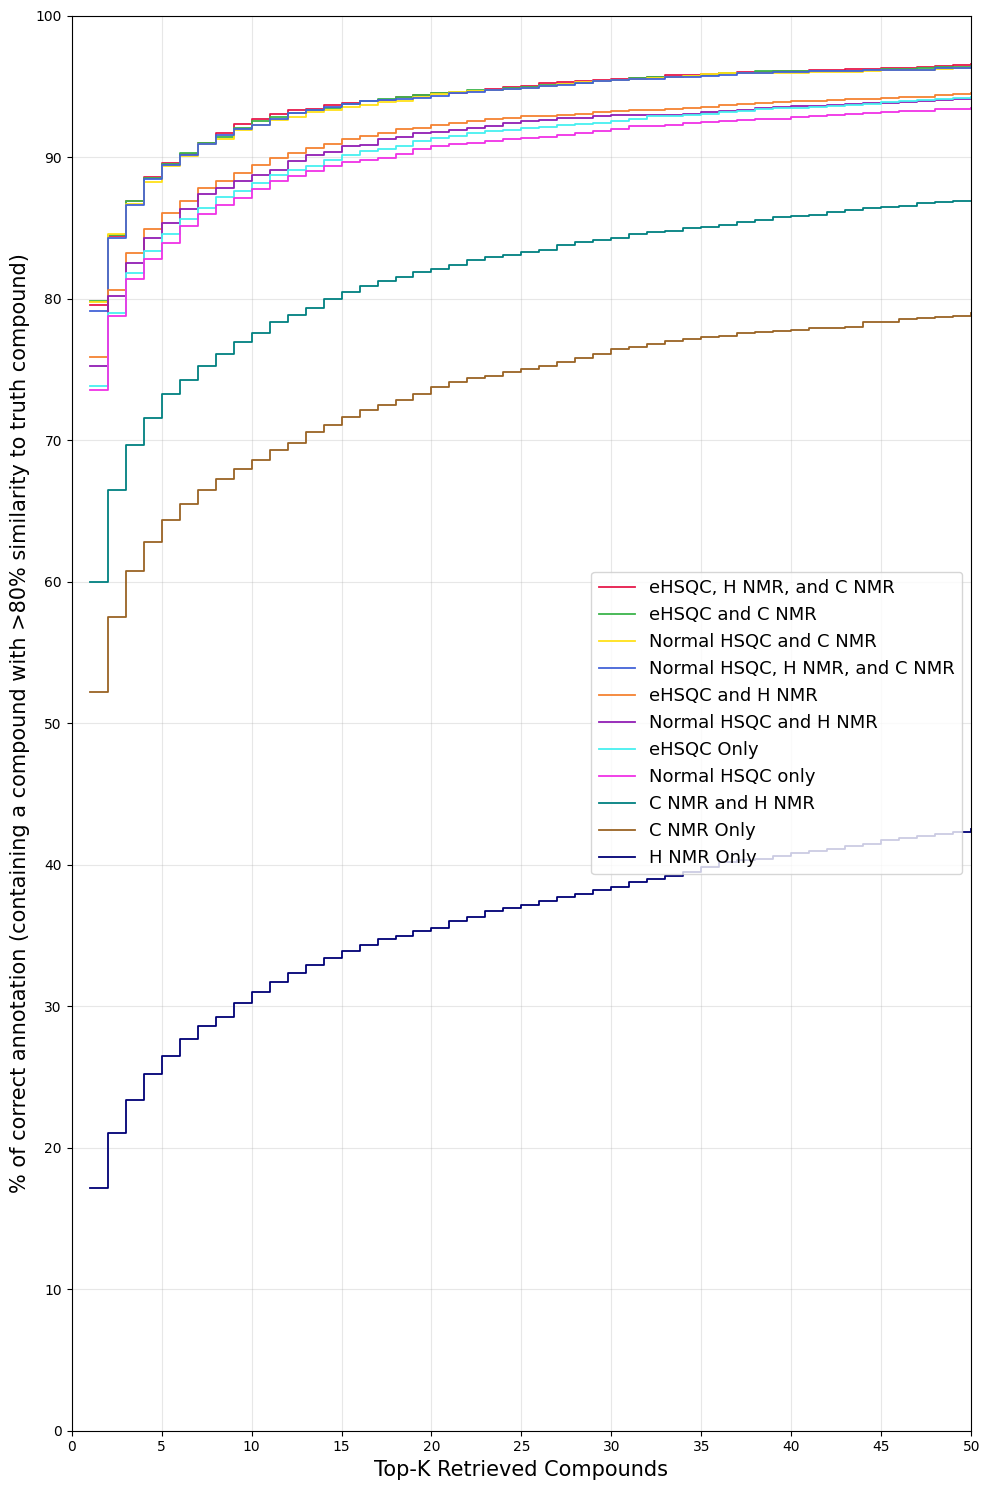

In [17]:
plot_topk_accuracy(mean_rank_records, max_k=50, title="")#Structure Annotation, using molecular weight

In [13]:
from collections import defaultdict

## without MW
mean_rank_records_no_mw = defaultdict(list)
for i in range(11):
    loader_idx = i
    if i == 7: # Normal HSQC only
        loader_idx = 3
    if i == 8: # Normal HSQC, H NMR, and C NMR
        loader_idx = 0
    if i == 9: # Normal HSQC and H NMR
        loader_idx = 1
    if i == 10: # Normal HSQC and C NMR
        loader_idx = 2
        
    for idx, batch in enumerate(tqdm.tqdm(test_dataloaders[loader_idx])):
        
        if i >= 7:
            # last column all zeros
            batch[0][:, -1] = 0
        with torch.no_grad():
            inputs, extra_info = batch
            (ground_smiles, names, NMR_type_indicator, path, superclasses) = zip(*extra_info)
        
            inputs = inputs.to(model.device)
            NMR_type_indicator = NMR_type_indicator[0].to(model.device)
            
            # remove mw
            inputs = inputs[:, :-1]
            # remove mw
            NMR_type_indicator = NMR_type_indicator[:-1]
            
            pred = model(inputs, NMR_type_indicator)
            pred=torch.sigmoid(pred) # sigmoid
            topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=50)
        idx_retrieval=0
        for value, (retrieval_smile, name, _, _), retrieved_FP in topk:
                
            if cos_sim_of_smiles(retrieval_smile, ground_smiles[0]) >= 0.8:
                break
            idx_retrieval += 1
        mean_rank_records_no_mw[loader_idx_to_name_mapping[i]].append(idx_retrieval)
        
        

  0%|          | 0/4056 [00:00<?, ?it/s]

100%|██████████| 4056/4056 [01:54<00:00, 35.58it/s]


In [26]:
NMR_type_indicator

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3]),)

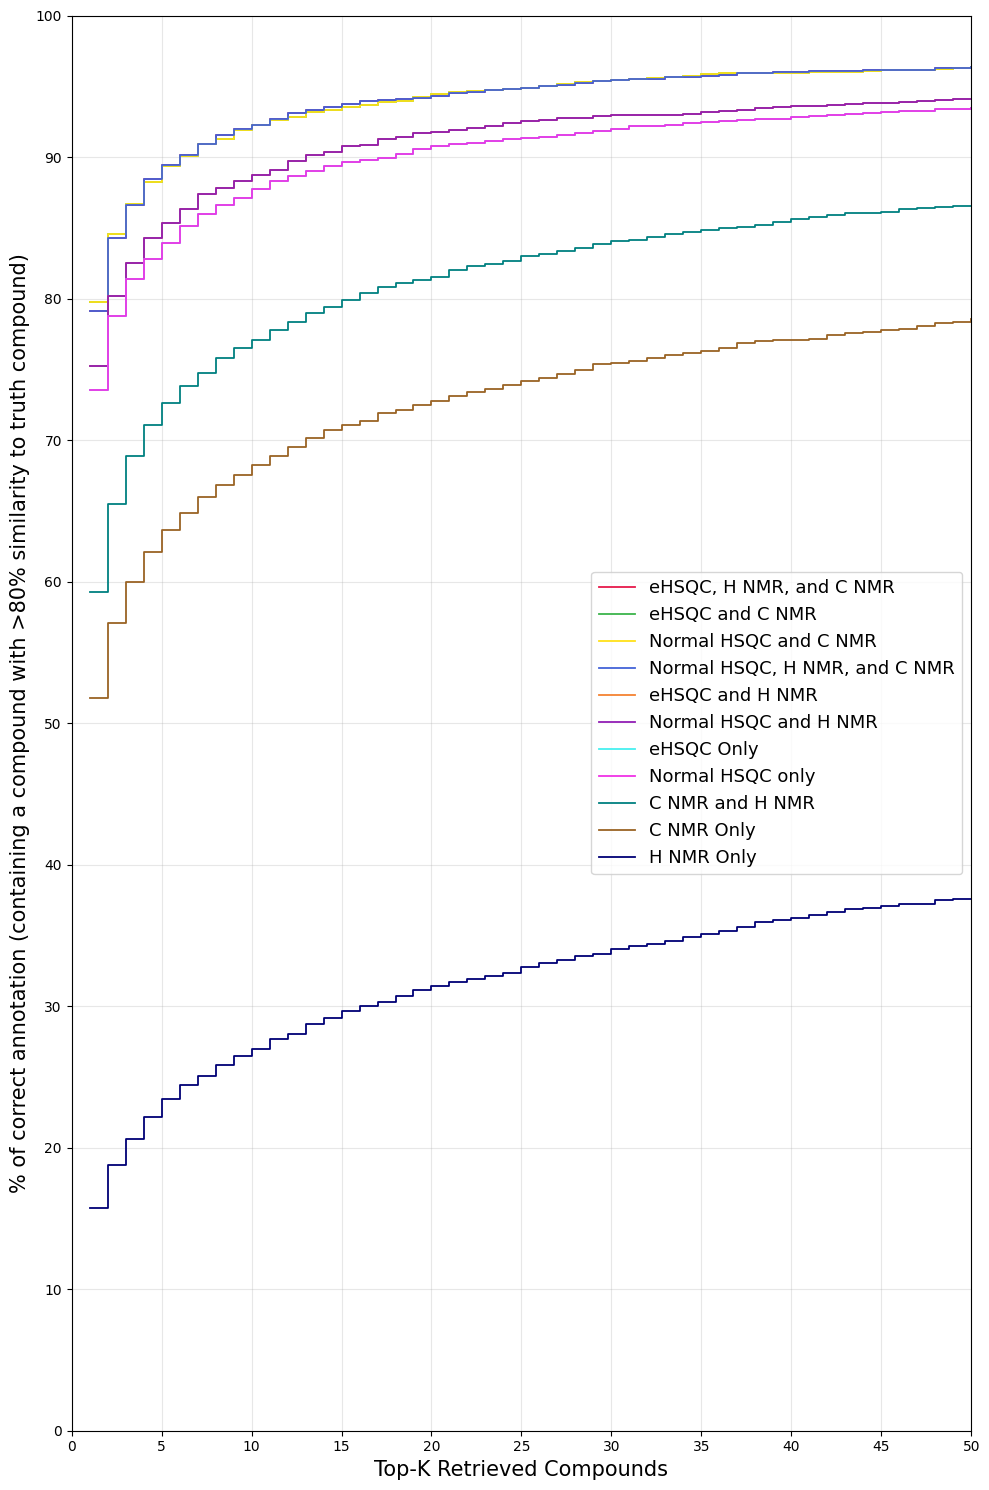

In [18]:
plot_topk_accuracy(mean_rank_records_no_mw, max_k=50, title="") #Structure Annotation, not using molecular weight

In [19]:
import pickle

save_dir= "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/inference/"

with open(save_dir + "topk_annotation_with_mw.pkl", 'wb') as file:
    pickle.dump(mean_rank_records, file)
with open(save_dir + "topk_annotation_without_mw.pkl", 'wb') as file:
    pickle.dump(mean_rank_records_no_mw, file)
   

In [11]:
import pickle
with open('/root/gurusmart/MorganFP_prediction/inference_data/coconut_loutus_hyun_training/smiles_to_np_classes.pkl', 'rb') as file:
    smiles_to_np_classes  = pickle.load(file)

In [12]:
len(smiles_to_np_classes)

526316

In [13]:

# for smiles, np_class in smiles_to_np_classes.items():
#     superclass_results = np_class.get("superclass_results")
#     if superclass_results is not None:
#         if len(superclass_results) > 1:
#             print(f"Smiles: {smiles}, Superclass Results: {superclass_results}")

In [14]:
def get_most_frequent_classes(lists_of_classes, k):
    """
    Get the most frequent classes from a list of lists.
    
    Args:
        lists_of_classes (list): List of lists containing classes.
        k (int): Number of most frequent classes to return.
        
    Returns:
        list: List of tuples containing the class and its frequency.
    """
    from collections import Counter
    
    # Flatten the list of lists
    all_classes = [item for sublist in lists_of_classes if sublist is not None for item in sublist]
    
    # Count the frequency of each class
    class_counts = Counter(all_classes)
    
    # Get the k most common classes
    most_common_classes = class_counts.most_common(k)
    
    return [x[0] for x in most_common_classes]
 

In [15]:
### performance of the NP class

from collections import defaultdict

## with MW
class_wise_accuracy = defaultdict(lambda: defaultdict(list))
for i in range(8):
    loader_idx = i
    if i == 7:
        loader_idx = 3
        
    for idx, batch in enumerate(tqdm.tqdm(test_dataloaders[loader_idx])):
        
        if i == 7:
            # last column all zeros
            batch[0][:, -1] = 0
        with torch.no_grad():
            inputs, extra_info = batch
            (ground_smiles, names, NMR_type_indicator, path, superclasses) = zip(*extra_info)
            inputs = inputs.to(model.device)
            NMR_type_indicator = NMR_type_indicator[0].to(model.device)
            pred = model(inputs, NMR_type_indicator)
            pred=torch.sigmoid(pred) # sigmoid
            topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=10)
        
        retrieved_smiles = [retrieval_smile for value, (retrieval_smile, name, _, _), retrieved_FP in topk]
        
        ground_superclass = smiles_to_np_classes[ground_smiles[0]].get("superclass_results")
        if ground_superclass is None:
            continue
        retrieved_NP_superclasses = [smiles_to_np_classes[smile].get("superclass_results") for smile in retrieved_smiles]
        most_frequent_classes = get_most_frequent_classes(retrieved_NP_superclasses, k = len(ground_superclass))
        for superclass in ground_superclass:
            class_wise_accuracy[loader_idx_to_name_mapping[i]][superclass].append(superclass in most_frequent_classes)

100%|██████████| 4056/4056 [00:44<00:00, 91.86it/s]


In [16]:
for model_name, class_accuracy in class_wise_accuracy.items():
    for superclass, accuracies in class_accuracy.items():
        accuracy = sum(accuracies) / len(accuracies) * 100
        print(f"Model: {model_name}, Superclass: {superclass}, Accuracy: {accuracy:.2f}%")

Model: All Inputs, Superclass: Saccharides, Accuracy: 90.00%
Model: All Inputs, Superclass: Diterpenoids, Accuracy: 94.54%
Model: All Inputs, Superclass: Monoterpenoids, Accuracy: 84.96%
Model: All Inputs, Superclass: Sesquiterpenoids, Accuracy: 92.14%
Model: All Inputs, Superclass: Coumarins, Accuracy: 92.22%
Model: All Inputs, Superclass: Isoflavonoids, Accuracy: 94.68%
Model: All Inputs, Superclass: Phenolic acids (C6-C1), Accuracy: 76.32%
Model: All Inputs, Superclass: Macrolides, Accuracy: 93.33%
Model: All Inputs, Superclass: Lignans, Accuracy: 96.26%
Model: All Inputs, Superclass: Tryptophan alkaloids, Accuracy: 93.10%
Model: All Inputs, Superclass: Pseudoalkaloids, Accuracy: 91.38%
Model: All Inputs, Superclass: Oligopeptides, Accuracy: 97.89%
Model: All Inputs, Superclass: Triterpenoids, Accuracy: 98.24%
Model: All Inputs, Superclass: Nicotinic acid alkaloids, Accuracy: 93.10%
Model: All Inputs, Superclass: Fatty acyls, Accuracy: 95.74%
Model: All Inputs, Superclass: Flavonoid

In [17]:
class_wise_accuracy_copy = class_wise_accuracy.copy()
class_wise_accuracy_copy['Normal HSQC \n(Non-Multiplicity-Edited)'] = class_wise_accuracy_copy['Normal HSQC (Non-Multiplicity-Edited)']

In [18]:
del class_wise_accuracy_copy['Normal HSQC (Non-Multiplicity-Edited)']

In [19]:
import pickle
with open("/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/top_20_NP_classes.pkl", "rb") as f:
    top_20_NP_classes = pickle.load(f)

In [20]:
top_20_NP_classes

['Diterpenoids',
 'Sesquiterpenoids',
 'Triterpenoids',
 'Flavonoids',
 'Steroids',
 'Tryptophan alkaloids',
 'Oligopeptides',
 'Monoterpenoids',
 'Lignans',
 'Isoflavonoids',
 'Coumarins',
 'Tyrosine alkaloids',
 'Linear polyketides',
 'Macrolides',
 'Small peptides',
 'Polycyclic aromatic polyketides',
 'Meroterpenoids',
 'Pseudoalkaloids',
 'Cyclic polyketides',
 'Aromatic polyketides']

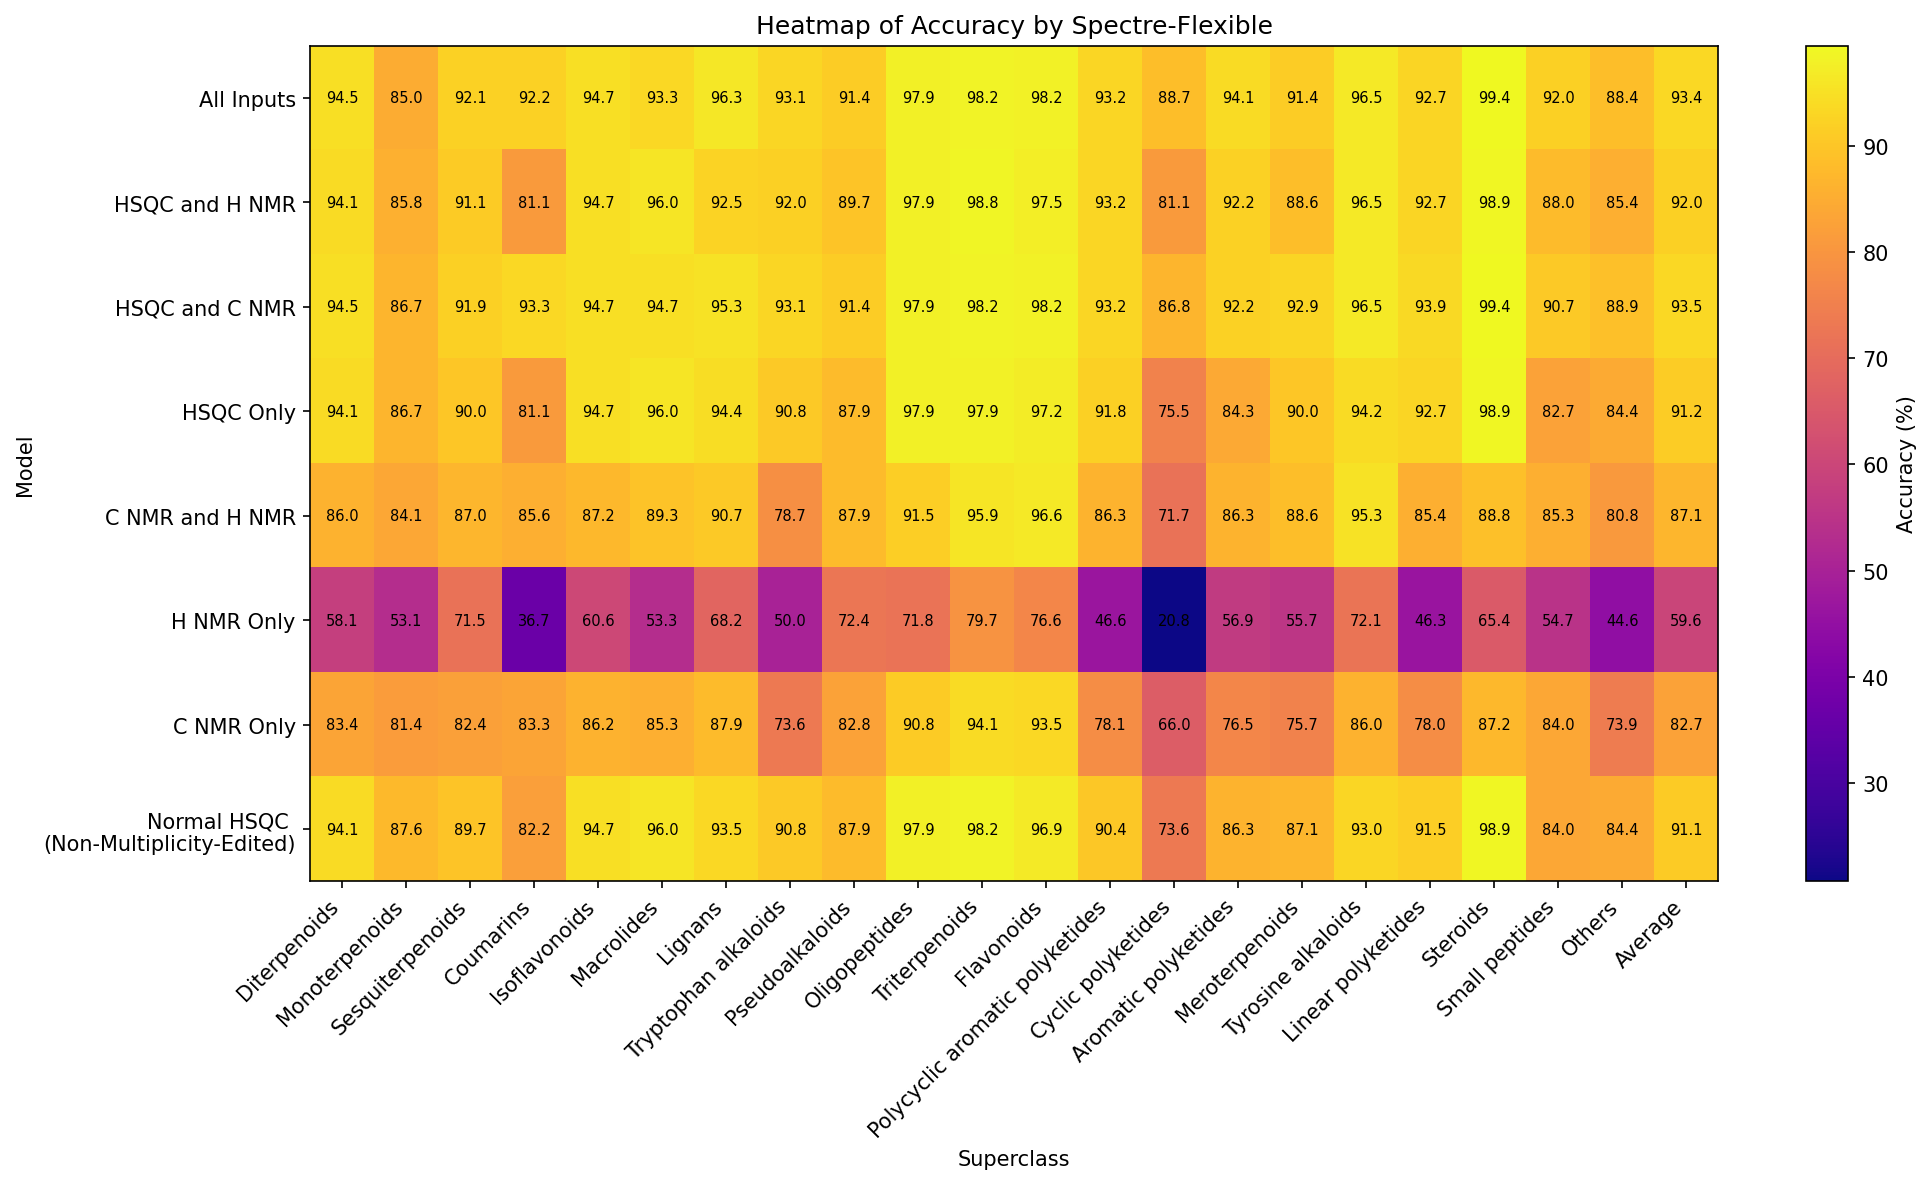

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
def plot_classwise_accuracy_heatmap_with_others(class_wise_accuracy, top_20_NP_classes):
    """
    Plots a heatmap of class-wise accuracy including a column for 'Others' (non-top-20 classes),
    and computes sample-weighted average accuracy for each model.
    """
    heatmap_data = {}
    model_totals = {}

    for model, superclass_accuracies in class_wise_accuracy.items():
        heatmap_data[model] = {}
        total_sum = 0
        total_count = 0
        others_sum = 0
        others_count = 0

        for superclass, accuracies in superclass_accuracies.items():
            count = len(accuracies)
            avg_accuracy = sum(accuracies) / count * 100

            if superclass in top_20_NP_classes:
                heatmap_data[model][superclass] = avg_accuracy
            else:
                others_sum += sum(accuracies)
                others_count += count

            total_sum += sum(accuracies)
            total_count += count

        # Add "Others" class
        if others_count > 0:
            heatmap_data[model]["Others"] = others_sum / others_count * 100
        else:
            heatmap_data[model]["Others"] = np.nan

        # Add sample-weighted model average
        model_totals[model] = (total_sum / total_count) * 100 if total_count > 0 else 0

    df = pd.DataFrame(heatmap_data).T  # Models as rows
    df["Average"] = df.index.map(model_totals)

    # Plot
    fig, ax = plt.subplots(figsize=(max(14, 0.5 * df.shape[1]), max(8, 0.4 * df.shape[0])), dpi=150)
    im = ax.imshow(df.values, cmap='plasma', aspect='auto')

    # Set ticks and labels
    ax.set_xticks(np.arange(df.shape[1]))
    ax.set_yticks(np.arange(df.shape[0]))
    ax.set_xticklabels(df.columns, rotation=45, ha="right")
    ax.set_yticklabels(df.index)

    # Annotate all cells
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            value = df.iloc[i, j]
            if not np.isnan(value):
                ax.text(j, i, f"{value:.1f}", ha="center", va="center", color="black", fontsize=7)

    # Colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.set_label("Accuracy (%)")

    ax.set_title("Heatmap of Accuracy by Spectre-Flexible")
    ax.set_xlabel("Superclass")
    ax.set_ylabel("Model")

    plt.tight_layout()
    plt.show()



# Test with dummy data
plot_classwise_accuracy_heatmap_with_others(class_wise_accuracy_copy, top_20_NP_classes)




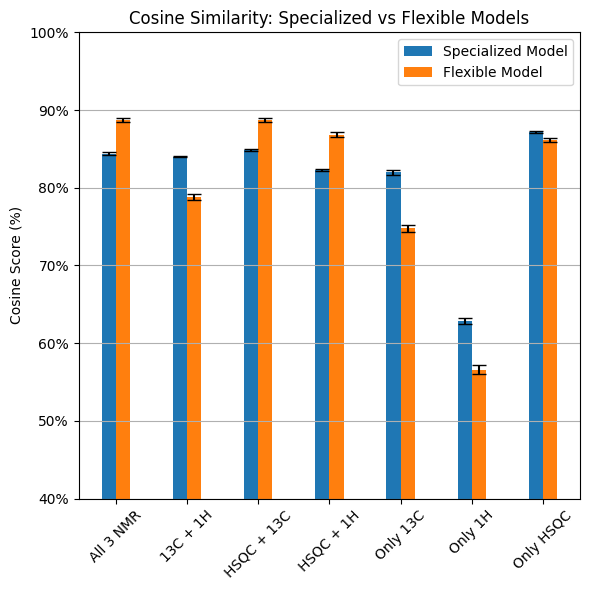

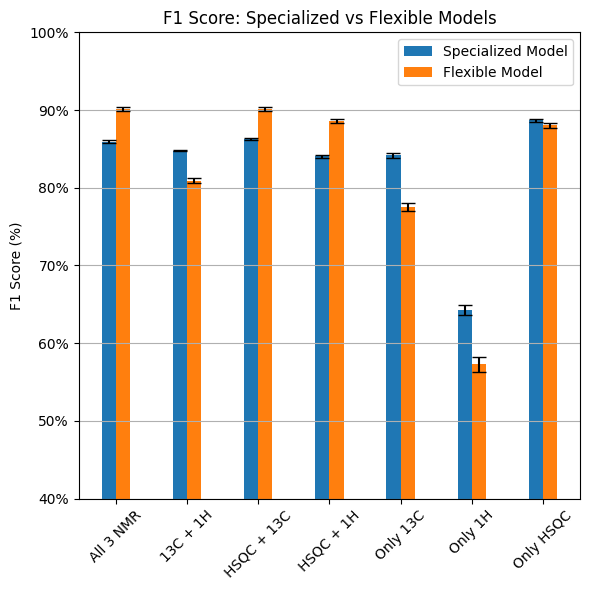

In [ ]:
# cosine and f1

from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import numpy as np


# Redefine values to cross-check with provided table
input_types = [
    "All 3 NMR",
    "13C + 1H",
    "HSQC + 13C",
    "HSQC + 1H",
    "Only 13C",
    "Only 1H",
    "Only HSQC"
]

x = np.arange(len(input_types))
width = 0.2
# Provided data: mean and std
cosine_specialized = [84.36, 84.00, 84.85, 82.25, 81.96, 62.83, 87.14]
cosine_specialized_err = [0.18, 0.08, 0.18, 0.14, 0.35, 0.43, 0.15]

cosine_flexible = [88.76, 78.80, 88.73, 86.85, 74.76, 56.55, 86.17]
cosine_flexible_err = [0.24, 0.34, 0.30, 0.27, 0.45, 0.57, 0.26]

f1_specialized = [85.91, 84.75, 86.29, 84.04, 84.18, 64.27, 88.66]
f1_specialized_err = [0.17, 0.08, 0.17, 0.17, 0.35, 0.61, 0.14]

f1_flexible = [90.17, 80.91, 90.14, 88.61, 77.53, 57.29, 88.01]
f1_flexible_err = [0.26, 0.33, 0.30, 0.26, 0.47, 0.96, 0.26]

# Plot Cosine Score with error bars
plt.figure(figsize=(6, 6))
plt.bar(x - width/2, cosine_specialized, width, yerr=cosine_specialized_err, capsize=5, label='Specialized Model')
plt.bar(x + width/2, cosine_flexible, width, yerr=cosine_flexible_err, capsize=5, label='Flexible Model')
plt.xticks(x, input_types, rotation=45)
plt.ylim(40, 100)

plt.ylabel('Cosine Score (%)')
plt.title('Cosine Similarity: Specialized vs Flexible Models')
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# Plot F1 Score with error bars
plt.figure(figsize=(6, 6))
plt.bar(x - width/2, f1_specialized, width, yerr=f1_specialized_err, capsize=5, label='Specialized Model')
plt.bar(x + width/2, f1_flexible, width, yerr=f1_flexible_err, capsize=5, label='Flexible Model')
plt.xticks(x, input_types, rotation=45)
plt.ylabel('F1 Score (%)')
plt.ylim(40, 100)
plt.title('F1 Score: Specialized vs Flexible Models')
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()
